In [1]:
import os, copy, time, sys, random
import pandas as pd, numpy as np
from datetime import datetime

import torch
import torch.nn as nn


import numpy as np


# Custom Imports:
from utils.pipelines import preprocess_df, preprocess_price
from utils.split import time_split
from utils.device import get_device
from collections import deque


import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'utils'

In [2]:
import pandas_ta
from ta.trend import SMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi


def add_indicator(df:pd.DataFrame, 
                  indicator_list:list = ['sma7','sma25','sma99','bb_bbm','bb_bbh',
                                         'bb_bbl','psar','MACD','RSI','ema7','ema25',
                                         'ema99', 'super_trend', 'super_trend_s',
                                         'super_trend_l', 'log_return']
    ):
    
    """ Adding list of indicators and fill nan-values """
    
    assert all(indicator in ['sma7','sma25','sma99','bb_bbm','bb_bbh',
                             'bb_bbl','psar','MACD','RSI','ema7','ema25',
                             'ema99', 'super_trend', 'super_trend_s',
                             'super_trend_l', 'log_return'] 
           for indicator in indicator_list), f'Unknown indicator {indicator}!'
    
    if 'sma7' in indicator_list:
        df["sma7"] = SMAIndicator(close=df["Close"], window=7, fillna=True).sma_indicator()
     
    if 'sma25' in indicator_list:
        df["sma25"] = SMAIndicator(close=df["Close"], window=25, fillna=True).sma_indicator()
        
    if 'sma99' in indicator_list:
        df["sma99"] = SMAIndicator(close=df["Close"], window=99, fillna=True).sma_indicator()
        
    if 'ema7' in indicator_list:   
        df["ema7"] = pandas_ta.ema(df["Close"], length=7).fillna(method = 'backfill')
        
    if 'ema25' in indicator_list:   
        df["ema25"] = pandas_ta.ema(df["Close"], length=25).fillna(method = 'backfill')

    if 'ema99' in indicator_list:   
        df["ema99"] = pandas_ta.ema(df["Close"], length=99).fillna(method = 'backfill')
    
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)
    
    if 'bb_bbm' in indicator_list:
        df['bb_bbm'] = indicator_bb.bollinger_mavg().fillna(method = 'backfill')
        
    if 'bb_bbh' in indicator_list:     
        df['bb_bbh'] = indicator_bb.bollinger_hband().fillna(method = 'backfill')
        
    if 'bb_bbl' in indicator_list: 
        df['bb_bbl'] = indicator_bb.bollinger_lband().fillna(method = 'backfill')

    if 'psar' in indicator_list: 
        indicator_psar = PSARIndicator(high=df["High"], low=df["Low"], close=df["Close"], step=0.02, max_step=2, fillna=True)
        df['psar'] = indicator_psar.psar()
    
    if 'MACD' in indicator_list: 
        df["MACD"] = macd(close=df["Close"], window_slow=26, window_fast=12, fillna=True) 
    
    if 'RSI' in indicator_list: 
        df["RSI"] = rsi(close=df["Close"], window=14, fillna=True)
        
        
    if 'super_trend' in indicator_list: 
        super_trend = pandas_ta.supertrend(high=df["High"], low = df["Low"], close = df["Close"], length = 10, multiplier=4.0)
        df['super_trend'] = super_trend['SUPERT_10_4.0'].fillna(method = 'backfill')
        
        if 'super_trend_s' in indicator_list: 
            df['super_trend_s'] = super_trend['SUPERTl_10_4.0'].fillna(method = 'backfill')

        if 'super_trend_l' in indicator_list: 
            df['super_trend_l'] = super_trend['SUPERT_10_4.0'].fillna(method = 'backfill')
        
    if 'log_return' in indicator_list: 
        df['log_return'] = pandas_ta.log_return(df['Close'], cumulative=False).fillna(method = 'backfill')
        
    if 'percent_return' in indicator_list: 
        df['percent_return'] = pandas_ta.percent_return(df['Close'], cumulative=False).fillna(method = 'backfill')   
    
    return df

def preprocess(df_path:str = "" , indicator_list:list = [], save_preprocessed:bool = True):
    """ Given the path of the data frame consist of OHLCV with date times, reads and adds indicator
        with given list. Save preprocessed data frame if save_preprocessed True """
    
    df = pd.read_csv(df_path)
    df = df[['Date','Open','High','Low','Close', 'Volume']].sort_values('Date')
    
    df['Date'] = df['Date'].apply(lambda x : x[:16])

    assert unique_cols(df['Date'].apply(lambda x : len(x))), 'Date length must be same!'
    
    if len(indicator_list) > 0:
        
        ind = "".join([indicator[0] for indicator in indicator_list])
        
        df_ind_path = f'{df_path}_with_indicators_{ind}.csv'
        
        if not os.path.exists(df_ind_path):
            df = add_indicator(df, indicator_list)
            
            if save_preprocessed:
                print(f' Preprocessed data frame is saved to the location: {df_ind_path}')
                df.to_csv(df_ind_path)
            
        else:
            print(f' Preprocessed data fetched from the location: {df_ind_path}')
            df = pd.read_csv(df_ind_path)
            
    if 'Unnamed: 0' in df.columns.tolist():
        df.drop(['Unnamed: 0'], 1, inplace = True)
        
    return df
        
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

In [3]:
df_path = './data/BTCUSDT-15m-2017-08-17 04_00-2021-06-13 16_45.csv'

indicator_list = [
                  #'sma7', 'sma25', 'sma99',
                  'bb_bbm','bb_bbh', 'bb_bbl',
                  'psar','MACD', 'RSI',
                  'ema7', 'ema25', 'ema99',
                  'log_return',
                  'super_trend',
                  #'super_trend_s',
                  #'super_trend_l'
]

ohlcv_list = ['Open', 'High','Low','Close', 'Volume']
reward_strategy = 'PnL'

df = preprocess(df_path, indicator_list = indicator_list)

last_6_hour = 24 
last_24_hour = last_6_hour * 4
last_2_day = last_24_hour * 2
last_1_week = last_24_hour * 7

lookback_window_size = last_1_week
test_window = 1400
train_df, test_df = time_split(df, lookback_window_size, test_window)

 Preprocessed data fetched from the location: ./data/BTCUSDT-15m-2017-08-17 04_00-2021-06-13 16_45.csv_with_indicators_bbbpMReeels.csv


In [4]:
# normalize the dataset
data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        # scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
train_df_scaled = scaler.fit_transform(train_df.values[:, 1:])
test_df_scaled = scaler.fit_transform(test_df.values[:, 1:])
#dataset_scaled = numpy.array(dataset_scaled)

In [5]:
train_df_scaled.shape

(131465, 16)

In [6]:
train_df.shape, test_df.shape

((131465, 17), (2072, 17))

In [7]:
train_df.isna().sum().sum()

0

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return np.array(dataX, dtype = np.float16), np.array(dataY, dtype = np.float16)

In [9]:
X_train, y_train = create_dataset(train_df_scaled, look_back=120)
X_test, y_test = create_dataset(test_df_scaled, look_back=120)

131344
1951


In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((131344, 120, 16), (131344, 16), (1951, 120, 16), (1951, 16))

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

batch_size = 1
timesteps = X_train.shape[1]
input_dim = X_train.shape[2]

model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(32, batch_input_shape = (batch_size, timesteps, input_dim), stateful = True, dropout=0.2))
#model.add(Dense(10))    # not necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train[:, 3], epochs=5,
          batch_size=batch_size,
          shuffle=True,
          verbose=1)  

# Is Bitcoin Data Stationary?

In [20]:
log_diff = np.log(df['Close']).diff().fillna(method = 'backfill')

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
results = adfuller(log_diff)

In [24]:
print(f"P-value: {results[1]}")

P-value: 0.0


<AxesSubplot:>

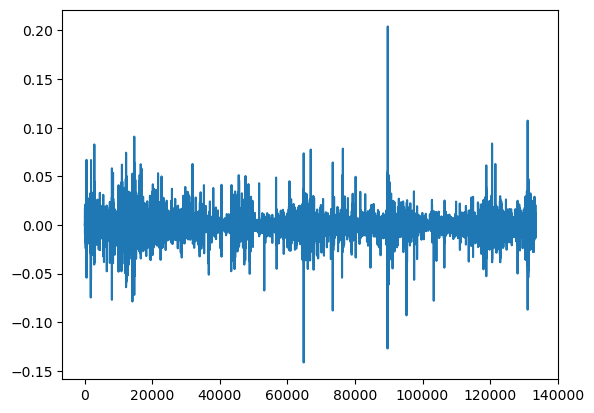

In [28]:
log_diff.plot()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

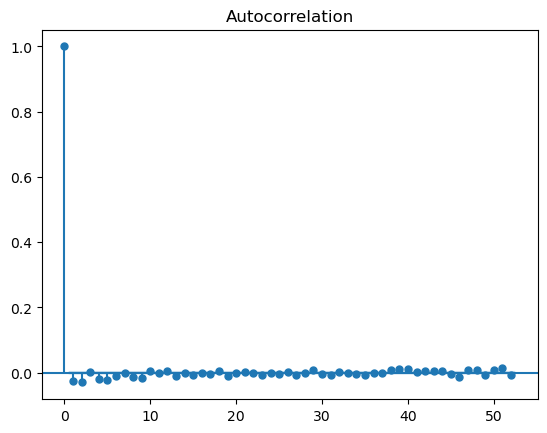

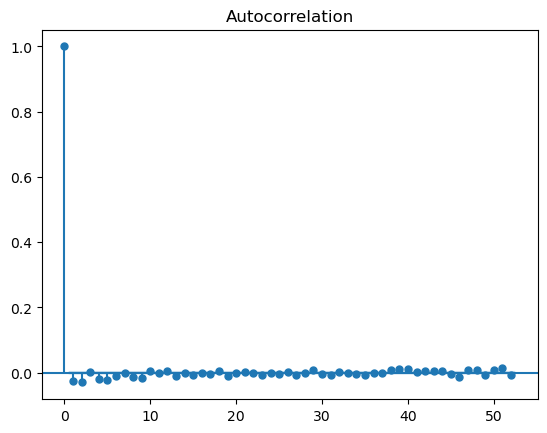

In [30]:
plot_acf(log_diff)

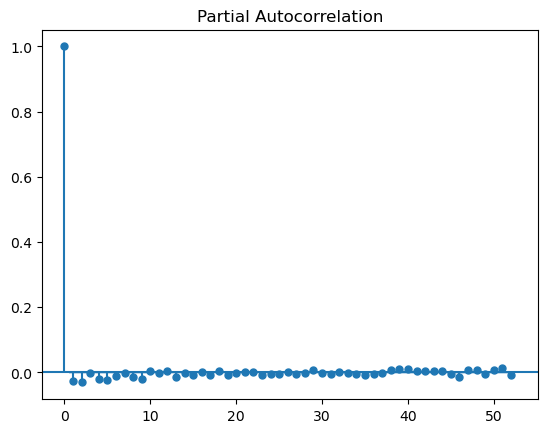

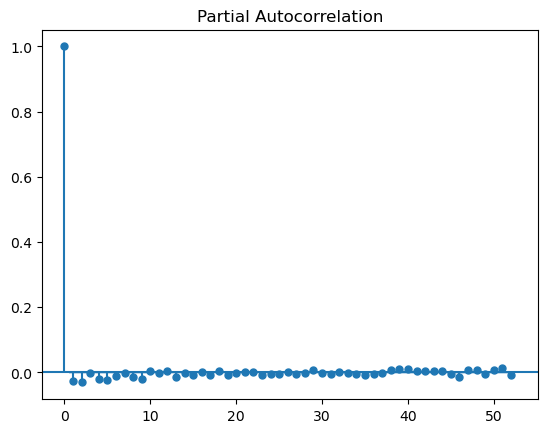

In [31]:
plot_pacf(log_diff)

In [32]:
from tqdm import tqdm

def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [35]:
# Fitting the model to the training set
model = SARIMAX(log_diff, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                #freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [37]:
output.forecast(steps = 15)

133537    6.534247e-05
133538   -1.610084e-06
133539    3.967359e-08
133540   -9.775847e-10
133541    2.408837e-11
133542   -5.935541e-13
133543    1.462558e-14
133544   -3.603846e-16
133545    8.880126e-18
133546   -2.188125e-19
133547    5.391691e-21
133548   -1.328550e-22
133549    3.273640e-24
133550   -8.066476e-26
133551    1.987636e-27
Name: predicted_mean, dtype: float64